<a href="https://colab.research.google.com/github/Dighvijay/HapticsML/blob/main/MLforHaptics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
"""import datetime
import scipy.fftpack"""
import pandas as pd
"""import os"""
from scipy import signal
import random
from tensorboard.plugins.hparams import api as hp
from tensorflow import feature_column
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
column_names = ["signalValue", "filteredValue"]


df = pd.DataFrame(columns = column_names)
frames = []
  
for i in range(99):
    fileSt ='/content/drive/MyDrive/SN/Output/accel'+str(i)+'.csv'
    train_data = pd.read_csv(fileSt)
    signalArrayTrain = train_data['accel'].to_numpy()
    data = {'signalValue': signalArrayTrain}
    df2 = pd.DataFrame(data=data)
    frames.append(df2)
    
result = pd.concat(frames)  

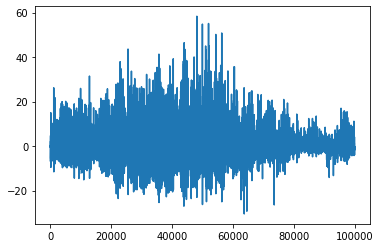

In [ ]:
X_values = result.to_numpy()
X_values = np.reshape(np.ravel(X_values), (99, 100000))
import matplotlib.pyplot as plt
plt.plot(X_values[0])

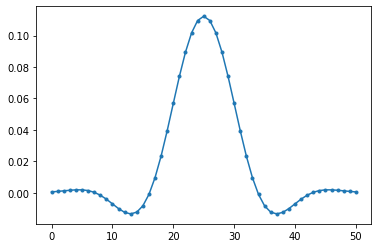

In [ ]:
num_taps = 51 #it helps to use an odd number of taps
cut_off = 1800 # Hz
sample_rate = 32000 # Hz

# creating the low pass filter
h = signal.firwin(num_taps, cut_off, nyq=sample_rate/2)

# Plotting the impulse response
plt.plot(h, '.-')
plt.show()

[ 8.01876595e-06 -1.39919276e-05 -5.03513711e-05 ... -1.26847349e+00
 -1.28491630e+00 -1.30000658e+00]

[ 0.014201 -0.047297 -0.045746 ... -1.109744 -0.93385  -1.097222]


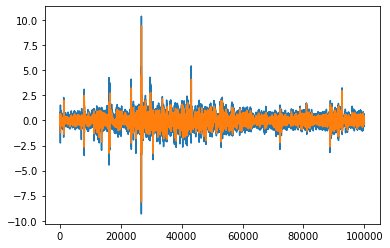

In [ ]:
Y_values = np.zeros((99,100000))
for i in range(99):
  Y_values[i] = signal.lfilter(h, 1.0, X_values[i])
print(Y_values[0])
print("")
print(X_values[0])
plt.plot(X_values[1])
plt.plot(Y_values[1])

In [ ]:
dnn_numinputs = 256
num_train_batch = 0
td = []
train_labels = []
lowValue_data = []
num_train_data = 1000
frames = []
res = result['signalValue']
resk  = res
for k in range(num_train_data-dnn_numinputs-1):
  td = np.concatenate((td,resk[k:k+dnn_numinputs]))
  low = random.randint(10,20)
  high = random.randint(25,50)
  sos = signal.butter(low, high, 'hp', fs=256, output='sos')
  yf = signal.sosfilt(sos, td)
  data = {'signalValue': td, 'filteredValue': yf,'LowValue':low, 'HighValue':high}
  df2 = pd.DataFrame(data=data)
  frames.append(df2)
  num_train_batch = num_train_batch + 1
kk = pd.concat(frames)  
kk

,signalValue,filteredValue,LowValue,HighValue
0,0.014201,0.000508,16,26
1,-0.047297,-0.004998,16,26
2,-0.045746,0.017048,16,26
3,-0.102248,-0.024582,16,26
4,-0.074234,0.014034,16,26
...,...,...,...,...
190203,-5.420769,-0.010659,20,45
190204,-5.027931,0.055912,20,45
190205,-4.682102,0.009517,20,45
190206,-4.538113,-0.033177,20,45


In [ ]:
num_train_batch

743

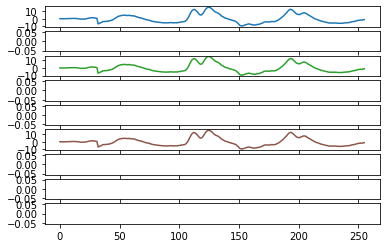

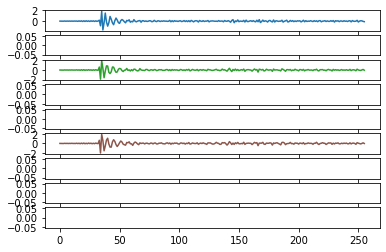

In [ ]:
from pandas.core.frame import DataFrame
from matplotlib import pyplot
p = 0
# for no in range(1,10):

wave = DataFrame()
filterWave = DataFrame()
for no in range(1,10):
  low = (0+no*256)
  high = (256+ no*256)
  wave[no] = kk['signalValue'][low:high]
  filterWave[no] = kk['filteredValue'][low:high]

wave.plot(subplots=True, legend=False)
filterWave.plot(subplots=True, legend=False)

pyplot.show()


In [ ]:
X = np.asarray(kk[['signalValue', 'LowValue', 'HighValue']])
Y = np.asarray(kk[['filteredValue']])
X_small = X
Y_small = Y
X_train, X_test, y_train, y_test = train_test_split(X_small, Y_small, test_size=0.33, shuffle= False)

# train, test = train_test_split(X_small, test_size=0.2)
X_remtrain, X_val,y_remtrain,y_val = train_test_split(X_train,y_train, test_size=0.25, shuffle= False)
print(len(X_remtrain), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

In [ ]:
# A simple regression model
model = tf.keras.Sequential()
model.add(layers.Dense(3, input_shape=(X_train.shape[1],)))
model.add(layers.Dense(3))
model.add(layers.Dense(3))
model.compile(loss='mse', optimizer='rmsprop')

# The fit() method - trains the model
model.fit(X_remtrain, y_remtrain, epochs=5)


# The evaluate() method - gets the loss statistics
model.evaluate(X_val, y_val)     
# returns: loss: 0.0022612824104726315

# The predict() method - predict the outputs for the given inputs
model.predict(X_test)
# model.predict(np.expand_dims(x[:3],1)) 
# returns: [ 0.65680361],[ 0.70067143],[ 0.70482892]


Epoch 1/5
3141/3141 [==============================] - 10s 2ms/step - loss: 10.7713
Epoch 2/5
3141/3141 [==============================] - 9s 3ms/step - loss: 1.8912
Epoch 3/5
3141/3141 [==============================] - 10s 3ms/step - loss: 1.8903
Epoch 4/5
3141/3141 [==============================] - 9s 3ms/step - loss: 1.8896
Epoch 5/5
1047/1047 [==============================] - 2s 2ms/step - loss: 2.0997


array([[-0.01553205, -0.00901039, -0.01111215],
       [-0.01508429, -0.008518  , -0.01063413],
       [-0.01361059, -0.00689703, -0.0090607 ],
       ...,
       [ 0.01008641,  0.02947046,  0.02325578],
       [ 0.00854017,  0.02776957,  0.02160481],
       [ 0.00191572,  0.02048363,  0.01453233]], dtype=float32)

In [ ]:
# #@title Default title text
# HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([64,128])) 
# HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([16,32]))
# HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.5))
# HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop']))
# HP_ACTIVATION = hp.HParam('activation', hp.Discrete(['sigmoid']))
# HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
# METRIC_ACCURACY = 'accuracy'
# METRIC_MSE = 'mean_squared_error'
# with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
#   hp.hparams_config(
#     hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER,HP_ACTIVATION],
#     metrics = [
#            hp.Metric("precision", display_name="Precision"),
#            hp.Metric("recall", display_name="Recall"),
#            hp.Metric("f1", display_name="F1 Score"),
#            hp.Metric('mean_squared_error', display_name='mse'),
#            hp.Metric('r2', display_name='r2')],
#   )



In [ ]:
# def train_test_model(hparams):
#   model = tf.keras.Sequential([
   
#     layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]),activation=hparams[HP_ACTIVATION]),
#     layers.Dropout(hparams[HP_DROPOUT]),
#     layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]),activation=hparams[HP_ACTIVATION]),
#     layers.Dense(1)
#   ])
#   model.compile(loss='mse', optimizer=hparams[HP_OPTIMIZER], metrics=['mean_squared_error'])

#   model.fit(X_train, y_train, epochs=5)
#   loss,  mse = model.evaluate(X_train, y_train)
#   return mse


In [ ]:
# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     mse = train_test_model(hparams)
#     tf.summary.scalar(METRIC_MSE, mse, step=1)

In [ ]:
# session_num = 0
# for num_units1 in HP_NUM_UNITS1.domain.values:
#   for num_units2 in HP_NUM_UNITS2.domain.values:
#     for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
#       for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):

#         for optimizer in HP_OPTIMIZER.domain.values:
#           for activation in HP_ACTIVATION.domain.values:
#             hparams = {
#                 HP_NUM_UNITS1: num_units1,
#                 HP_NUM_UNITS2: num_units2,
#                 HP_DROPOUT: dropout_rate,
#                 HP_L2: l2,
#                 HP_OPTIMIZER: optimizer,
#                 HP_ACTIVATION: activation
#                 }
#             run_name = "run-%d" % session_num
#             print('--- Starting trial: %s' % run_name)
#             print({h.name: hparams[h] for h in hparams})
#             run('/content/drive/MyDrive/SN/logs/hparam_tuning/' + run_name, hparams)
#             session_num += 1


--- Starting trial: run-0
{'num_units 1': 64, 'num_units 2': 16, 'dropout': 0.2, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop', 'activation': 'sigmoid'}
Epoch 1/5
 190/4188 [>.............................] - ETA: 10s - loss: 1.9211 - mean_squared_error: 1.8981

KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/logs/hparam_tuning

In [ ]:
# Define a simple sequential model
def create_model():
  model = tf.keras.Sequential([
  layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='sigmoid'),
  layers.Dropout(0.2),
  layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='sigmoid'),
  layers.Dense(1)
  ])
  model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy','mean_squared_error'])

  return model
  
  # # Create a basic model instance
  model = create_model()
  # # Display the model's architecture
  model.summary()  





  

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model = create_model()

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(X_train, y_train, epochs=10,callbacks=[cp_callback]) 

NameError: ignored

In [ ]:
# checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# batch_size = 32

# # Create a callback that saves the model's weights every 5 epochs
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path, 
#     verbose=1, 
#     save_weights_only=True,
#     save_freq=5*num_train_batch)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
# model.fit(train_images, 
#           train_labels,
#           epochs=50, 
#           batch_size=batch_size, 
#           callbacks=[cp_callback],
#           validation_data=(test_images, test_labels),
#           verbose=0)


model.fit(X_train, y_train, epochs=10)
loss, accuracy, mse = model.evaluate(X_train, y_train)


NameError: ignored

In [ ]:
!mkdir -p /content/drive/MyDrive/SN/saved_model
model.save('/content/drive/MyDrive/SN/saved_model/my_model') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/SN/saved_model/my_model/assets


In [ ]:
strt_time = datetime.datetime.now()
dnn_out = model.predict(X_test)
curr_time = datetime.datetime.now()
timedelta = curr_time - strt_time
print("DNN Time" ,timedelta.total_seconds())

DNN Time 322.620865


In [ ]:
keras_dnn_err = y_test - dnn_out
keras_dnn_err



array([[-2.01959655],
       [-2.19939094],
       [-2.31830436],
       ...,
       [ 0.05179694],
       [-0.05321926],
       [ 0.10200503]])

In [ ]:
dnn_scipy_mse = 10*np.log10(np.mean(pow(np.abs(keras_dnn_err),2)))
labels_sigpow = 10*np.log10(np.mean(pow(np.abs(y_test),2)))

print("Neural Network SNR compare to SciPy FFT: ", labels_sigpow - dnn_scipy_mse)


Neural Network SNR compare to SciPy FFT:  0.08411887650411787


array([[ 3.739604, 14.      , 37.      ],
       [ 3.633409, 14.      , 37.      ],
       [ 3.28388 , 14.      , 37.      ],
       ...,
       [-3.841479, 14.      , 44.      ],
       [-3.474722, 14.      , 44.      ],
       [-1.90357 , 14.      , 44.      ]])

In [ ]:
import numpy as np
import scipy as sp
import scipy.fftpack as fft
import scipy.linalg as la
import math

def calc_thd(data, signalFrequency, samplingRate, frequencyMargin):
    # only care about magnitude
    fftData = abs(fft.fft(data * np.hanning(len(data))))
    fftData[0] = 0 # ignore DC
    fftLen = len(fftData)/2
    baseI = fftLen * signalFrequency * 2 / samplingRate
    iMargain = baseI * frequencyMargin
    baseSignalLoc = baseI - iMargain / 2 + \
    np.argmax(fftData[baseI - iMargain /2: baseI + iMargain/2])
    peakLoc = np.argmax(fftData[:fftLen])
    if peakLoc != baseSignalLoc:
        return 1.0
    P0 = math.pow(la.norm(fftData[baseSignalLoc - iMargain/2: baseSignalLoc + iMargain/2]), 2)
    i = baseSignalLoc * 2
    Pothers = 0.0
    while i < fftLen:
        Pothers += math.pow(la.norm(fftData[i - iMargain/2: i + iMargain/2]), 2)
        i += baseSignalLoc

    return Pothers / P0

# test code
if __name__=="__main__":
    samplingRate = 44100
    durationInSec = 10
    signalFrequency = 1000
    samples = float(samplingRate) * float(durationInSec)
    index = np.linspace(0.0, samples, num=int(samples), endpoint=False)
    time = index / samplingRate
    multiplier = 2.0 * np.pi * signalFrequency / float(samplingRate)
    data = np.sin(index * multiplier)
    thd = calc_thd(data, signalFrequency, samplingRate, 0.02)


TypeError: ignored

In [ ]:
THD(y_test[1:10000])

Fundamental frequency not specified, estimated frequency = 4856485.65 Hz
THD will calculate 0 harmonic slots


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


IndexError: ignored

No handles with labels found to put in legend.


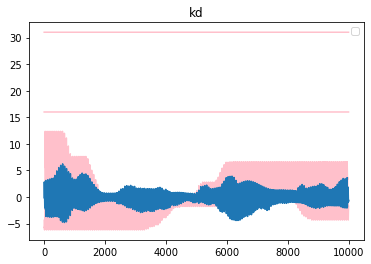

In [ ]:
plt.plot(X_test[1:10000],'pink')
plt.plot(y_test[1:10000])

plt.legend()
plt.title("kd")
plt.show()

In [ ]:
from scipy.signal.windows import general_cosine
from scipy.fftpack import next_fast_len
from numpy.fft import rfft, irfft
from numpy import argmax, mean, log, concatenate, zeros
import numpy as np
from waveform_analysis._common import rms_flat, parabolic
from waveform_analysis import A_weight


# This requires accurately measuring frequency component amplitudes, so use a
# flat-top window (https://holometer.fnal.gov/GH_FFT.pdf)
flattops = {
    'dantona3': [0.2811, 0.5209, 0.1980],
    'dantona5': [0.21557895, 0.41663158, 0.277263158, 0.083578947,
                 0.006947368],
    'SFT3F': [0.26526, 0.5, 0.23474],
    'SFT4F': [0.21706, 0.42103, 0.28294, 0.07897],
    'SFT5F': [0.1881, 0.36923, 0.28702, 0.13077, 0.02488],
    'SFT3M': [0.28235, 0.52105, 0.19659],
    'SFT4M': [0.241906, 0.460841, 0.255381, 0.041872],
    'SFT5M': [0.209671, 0.407331, 0.281225, 0.092669, 0.0091036],
    'FTSRS': [1.0, 1.93, 1.29, 0.388, 0.028],
    'FTNI': [0.2810639, 0.5208972, 0.1980399],
    'FTHP': [1.0, 1.912510941, 1.079173272, 0.1832630879],
    'HFT70': [1, 1.90796, 1.07349, 0.18199],
    'HFT95': [1, 1.9383379, 1.3045202, 0.4028270, 0.0350665],
    'HFT90D': [1, 1.942604, 1.340318, 0.440811, 0.043097],
    'HFT116D': [1, 1.9575375, 1.4780705, 0.6367431, 0.1228389, 0.0066288],
    'HFT144D': [1, 1.96760033, 1.57983607, 0.81123644, 0.22583558, 0.02773848,
                0.00090360],
    'HFT169D': [1, 1.97441842, 1.65409888, 0.95788186, 0.33673420, 0.06364621,
                0.00521942, 0.00010599],
    'HFT196D': [1, 1.979280420, 1.710288951, 1.081629853, 0.448734314,
                0.112376628, 0.015122992, 0.000871252, 0.000011896],
    'HFT223D': [1, 1.98298997309, 1.75556083063, 1.19037717712, 0.56155440797,
                0.17296769663, 0.03233247087, 0.00324954578, 0.00013801040,
                0.00000132725],
    'HFT248D': [1, 1.985844164102, 1.791176438506, 1.282075284005,
                0.667777530266, 0.240160796576, 0.056656381764, 0.008134974479,
                0.000624544650, 0.000019808998, 0.000000132974],
    }


def THDN(signal, fs, weight=None):
    """Measure the THD+N for a signal and print the results
    Prints the estimated fundamental frequency and the measured THD+N.  This is
    calculated from the ratio of the entire signal before and after
    notch-filtering.
    This notch-filters by nulling out the frequency coefficients ±10% of the
    fundamental
    TODO: Make R vs F reference a parameter (currently is R)
    TODO: Or report all of the above in a dictionary?
    """
    # Get rid of DC and window the signal
    signal = np.asarray(signal) + 0.0  # Float-like array
    # TODO: Do this in the frequency domain, and take any skirts with it?
    signal -= mean(signal)

    window = general_cosine(len(signal), flattops['HFT248D'])
    windowed = signal * window
    del signal

    # Zero pad to nearest power of two
    new_len = next_fast_len(len(windowed))
    windowed = concatenate((windowed, zeros(new_len - len(windowed))))

    # Measure the total signal before filtering but after windowing
    total_rms = rms_flat(windowed)

    # Find the peak of the frequency spectrum (fundamental frequency)
    f = rfft(windowed)
    i = argmax(abs(f))
    true_i = parabolic(log(abs(f)), i)[0]
    frequency = fs * (true_i / len(windowed))

    # Filter out fundamental by throwing away values ±10%
    lowermin = int(true_i * 0.9)
    uppermin = int(true_i * 1.1)
    f[lowermin: uppermin] = 0
    # TODO: Zeroing FFT bins is bad

    # Transform noise back into the time domain and measure it
    noise = irfft(f)
    # TODO: RMS and A-weighting in frequency domain?  Parseval?

    if weight is None:
        pass
    elif weight == 'A':
        # Apply A-weighting to residual noise (Not normally used for
        # distortion, but used to measure dynamic range with -60 dBFS signal,
        # for instance)
        noise = A_weight(noise, fs)
        # TODO: filtfilt? tail end of filter?
    else:
        raise ValueError('Weighting not understood')

    # TODO: Return a dict or list of frequency, THD+N?
    return rms_flat(noise) / total_rms


def THD(signal, fs):
    """Measure the THD for a signal
    This function is not yet trustworthy.
    Returns the estimated fundamental frequency and the measured THD,
    calculated by finding peaks in the spectrum.
    TODO: Make weighting a parameter
    TODO: Make R vs F reference a parameter (F as default??)
    """
    # Get rid of DC and window the signal
    signal = np.asarray(signal) + 0.0  # Float-like array
    # TODO: Do this in the frequency domain, and take any skirts with it?
    signal -= mean(signal)

    window = general_cosine(len(signal), flattops['HFT248D'])
    windowed = signal * window
    del signal

    # Find the peak of the frequency spectrum (fundamental frequency)
    f = rfft(windowed)
    i = argmax(abs(f))
    true_i = parabolic(log(abs(f)), i)[0]
    print('Frequency: %f Hz' % (fs * (true_i / len(windowed))))

    print('fundamental amplitude: %.3f' % abs(f[i]))

    # Find the values for the first 15 harmonics.  Includes harmonic peaks
    # only, by definition
    # TODO: Should peak-find near each one, not just assume that fundamental
    # was perfectly estimated.
    # Instead of limited to 15, figure out how many fit based on f0 and
    # sampling rate and report this "4 harmonics" and list the strength of each
    for x in range(2, 15):
        print('%.3f' % abs(f[i * x]), end=' ')

    THD = sum([abs(f[i*x]) for x in range(2, 15)]) / abs(f[i])
    print('\nTHD: %f%%' % (THD * 100))
    return

ModuleNotFoundError: ignored